In [1]:
import gym
from gym import wrappers
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor


In [3]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class Network(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, 16)
        self.l3 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

In [5]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return model(Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(2)]])


In [6]:
def learn():
    if len(memory) < BATCH_SIZE:
        return

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(BATCH_SIZE)
    batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

    batch_state = Variable(torch.cat(batch_state))
    batch_action = Variable(torch.cat(batch_action))
    batch_reward = Variable(torch.cat(batch_reward))
    batch_next_state = Variable(torch.cat(batch_next_state))

    # current Q values are estimated by NN for all actions
    current_q_values = model(batch_state).gather(1, batch_action)
    # expected Q values are estimated from actions which gives maximum Q value
    max_next_q_values = model(batch_next_state).detach().max(1)[0]
    expected_q_values = batch_reward + (GAMMA * max_next_q_values)

    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(current_q_values, expected_q_values)

    # backpropagation of loss to NN
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [7]:
def run_episode(e, environment):
    state = environment.reset()
    steps = 0
    while True:
        steps += 1
        environment.render()
        action = select_action(FloatTensor([state]))
        next_state, reward, done, _ = environment.step(action.item())
        

        # zero reward when attempt ends
        if done and steps < 200:
            reward = 0

        memory.push((FloatTensor([state]),
                     action,  # action is already a tensor
                     FloatTensor([next_state]),
                     FloatTensor([reward])))        
        learn()
        state = next_state
        if done:
            print("{2} Episode {0} finished after {1} steps"
                  .format(e, steps, '\033[92m' if steps >= 195 else '\033[99m'))
            episode_durations.append(steps)
            plot_durations()
            break

In [8]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

# Hyperparameters

In [9]:
# hyper parameters
EPISODES = 600  # number of episodes
EPS_START = 0.9  # e-greedy threshold start value
EPS_END = 0.01  # e-greedy threshold end value
EPS_DECAY = 200  # e-greedy threshold decay
GAMMA = 0.80  # Q-learning discount factor
LR = 0.0005  # NN optimizer learning rate
HIDDEN_LAYER = 24  # NN hidden layer size
BATCH_SIZE = 128  # Q-learning batch size

# Load environment & network

In [10]:
env = gym.make('CartPole-v1')
# env = wrappers.Monitor(env, './tmp/cartpole-v0-1', force=True)

model = Network()
if use_cuda:
    model.cuda()
memory = ReplayMemory(10000)
optimizer = optim.Adam(model.parameters(), LR)
steps_done = 0
episode_durations = []

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 0 finished after 21 steps


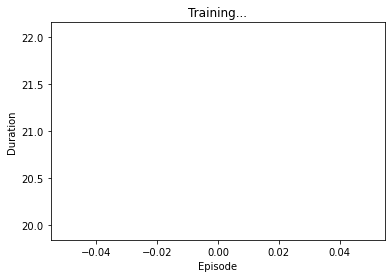

 Episode 1 finished after 14 steps


C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


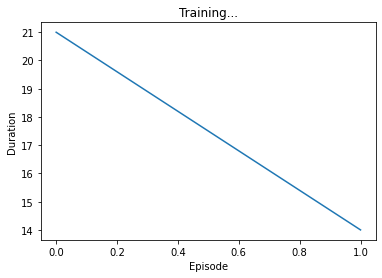

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 2 finished after 18 steps


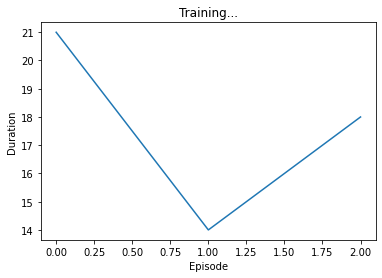

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 3 finished after 23 steps


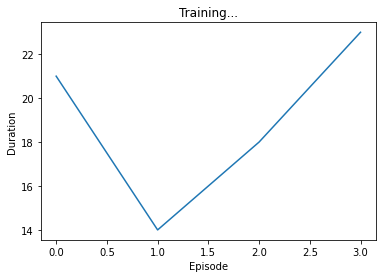

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 4 finished after 14 steps


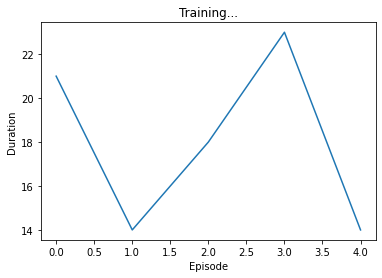

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 5 finished after 35 steps


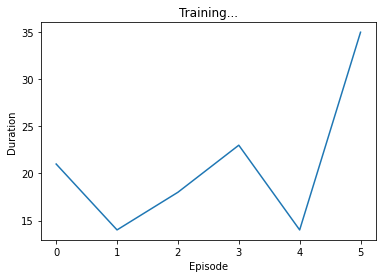

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 6 finished after 13 steps


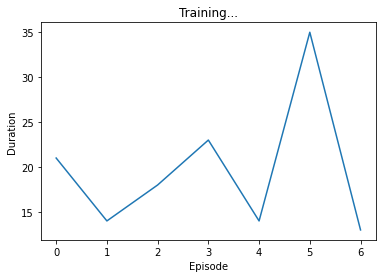

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 7 finished after 10 steps


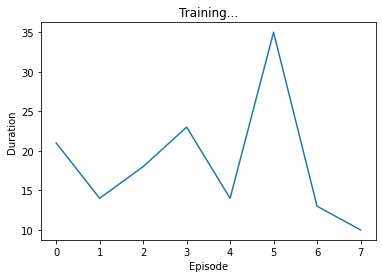

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 8 finished after 20 steps


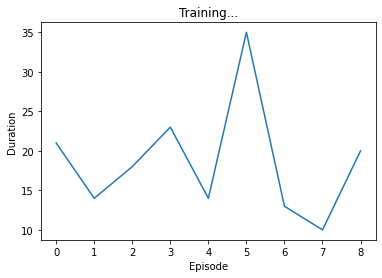

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 9 finished after 18 steps


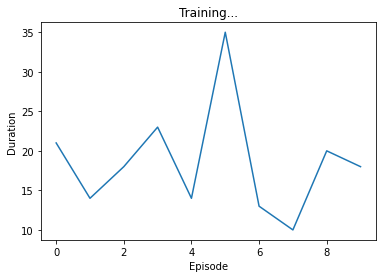

 Episode 10 finished after 8 steps


C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


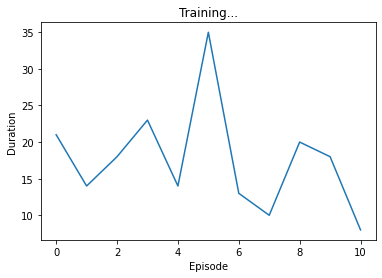

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 11 finished after 10 steps


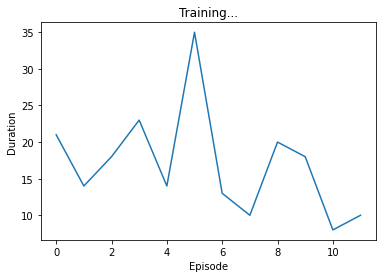

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 12 finished after 13 steps


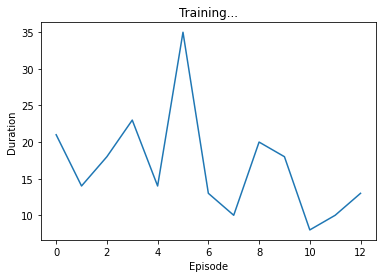

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 13 finished after 12 steps


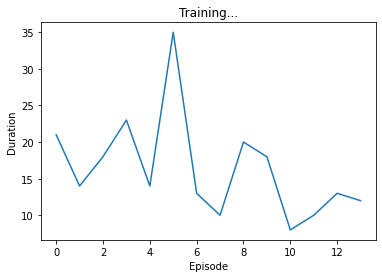

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 14 finished after 10 steps


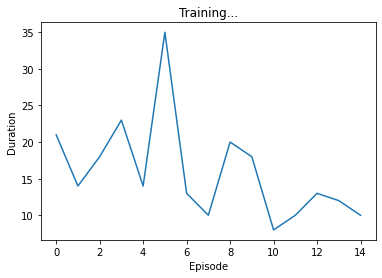

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 15 finished after 10 steps


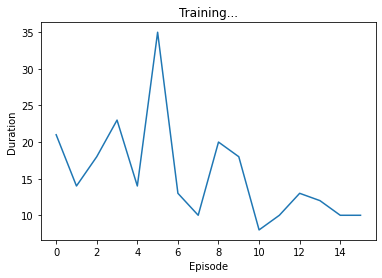

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 16 finished after 10 steps


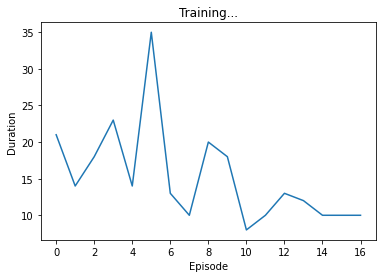

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 17 finished after 14 steps


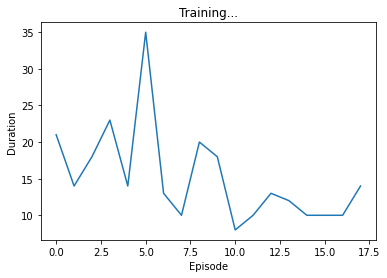

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 18 finished after 11 steps


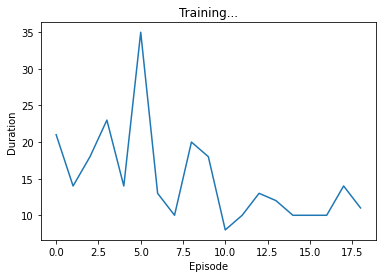

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 19 finished after 26 steps


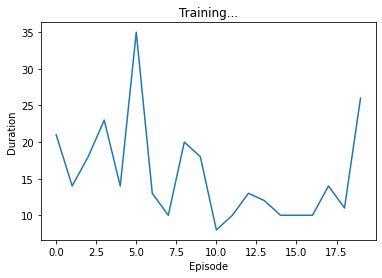

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 20 finished after 10 steps


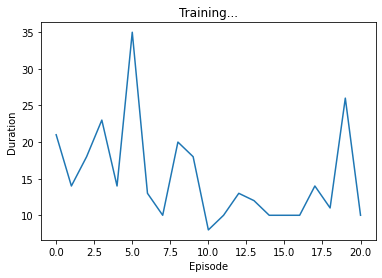

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 21 finished after 10 steps


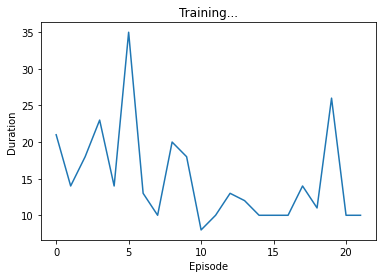

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 22 finished after 9 steps


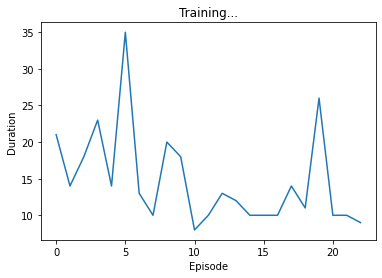

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 23 finished after 10 steps


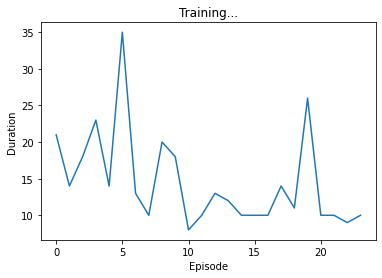

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 24 finished after 10 steps


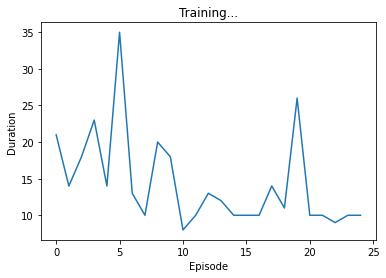

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 25 finished after 9 steps


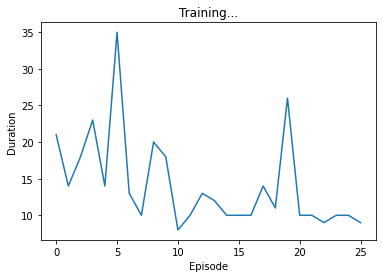

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 26 finished after 10 steps


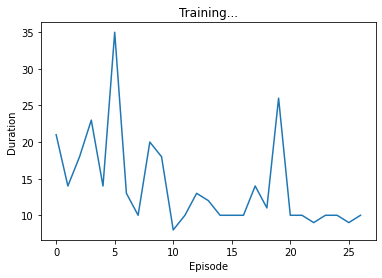

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 27 finished after 10 steps


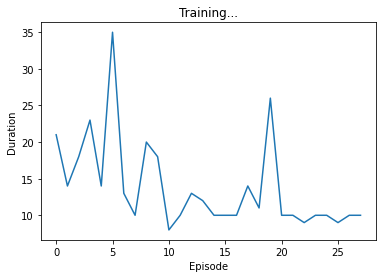

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 28 finished after 9 steps


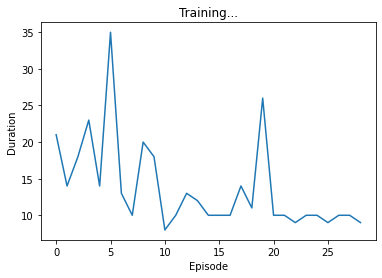

 Episode 29 finished after 8 steps


C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


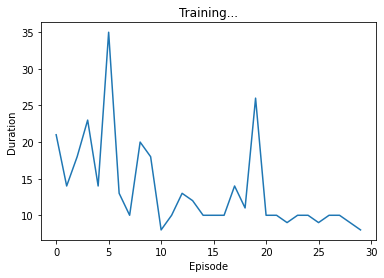

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 30 finished after 10 steps


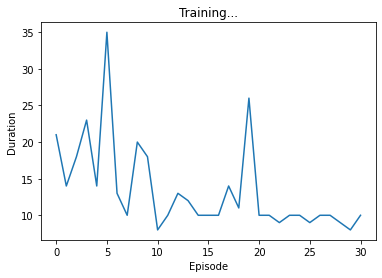

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 31 finished after 8 steps


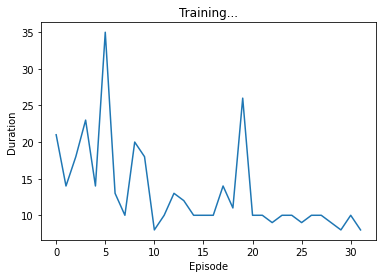

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 32 finished after 10 steps


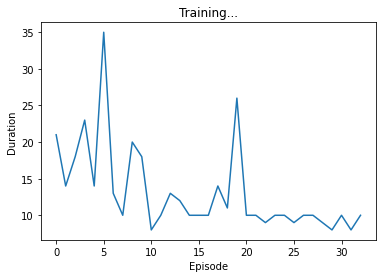

 Episode 33 finished after 8 steps


C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


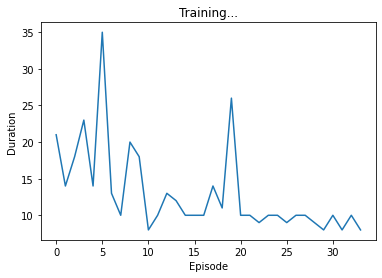

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 34 finished after 13 steps


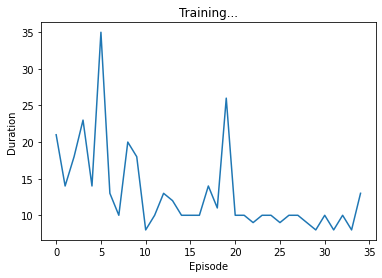

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 35 finished after 11 steps


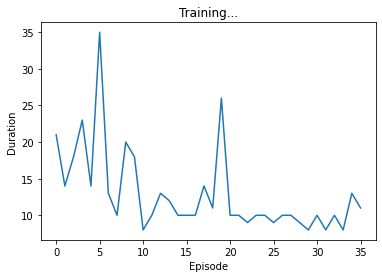

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 36 finished after 10 steps


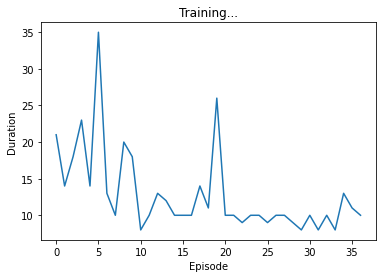

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 37 finished after 13 steps


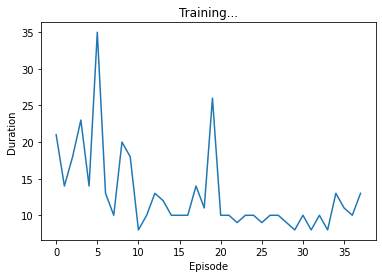

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 38 finished after 11 steps


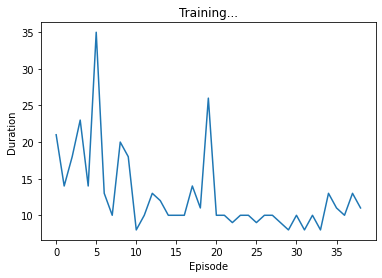

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 39 finished after 13 steps


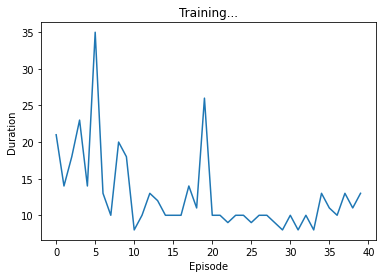

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 40 finished after 10 steps


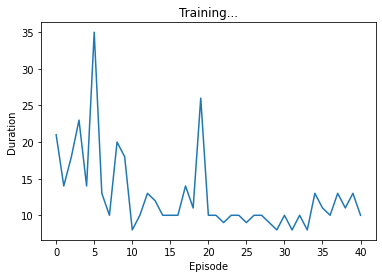

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 41 finished after 11 steps


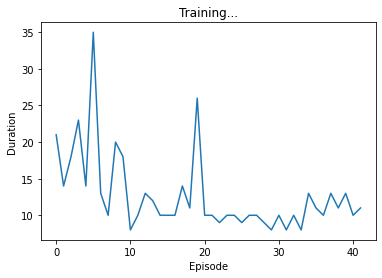

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 42 finished after 11 steps


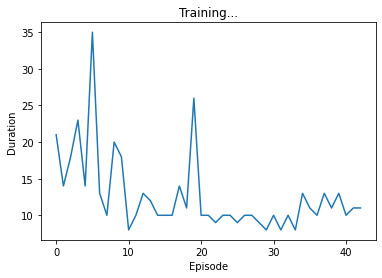

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 43 finished after 13 steps


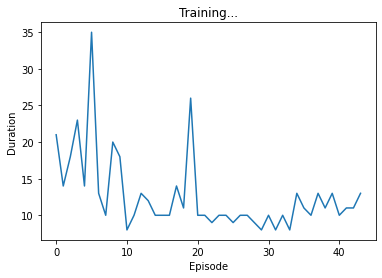

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 44 finished after 13 steps


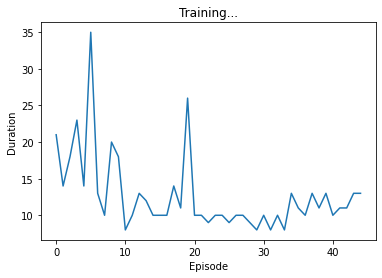

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 45 finished after 14 steps


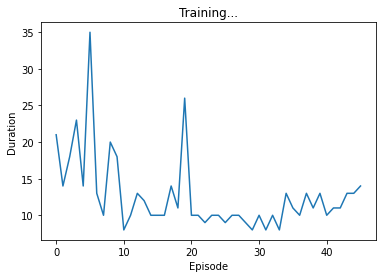

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 46 finished after 15 steps


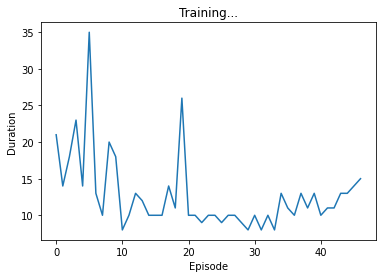

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 47 finished after 14 steps


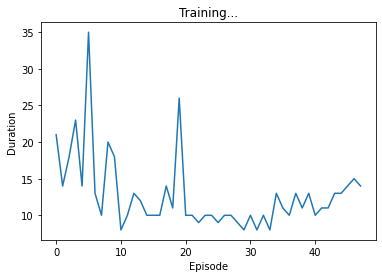

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 48 finished after 12 steps


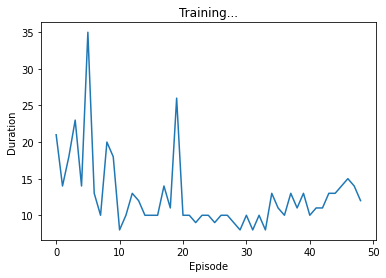

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 49 finished after 14 steps


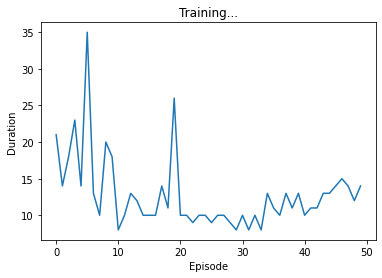

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 50 finished after 12 steps


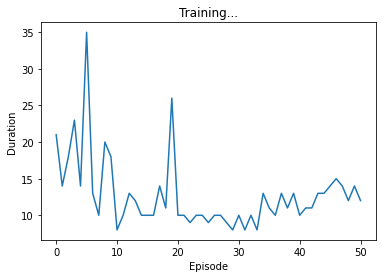

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 51 finished after 14 steps


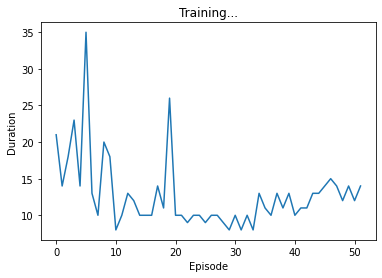

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 52 finished after 15 steps


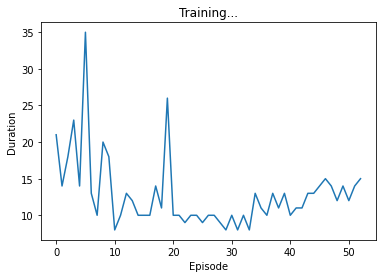

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 53 finished after 12 steps


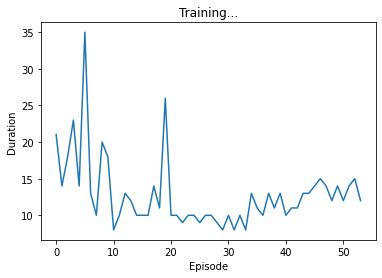

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 54 finished after 13 steps


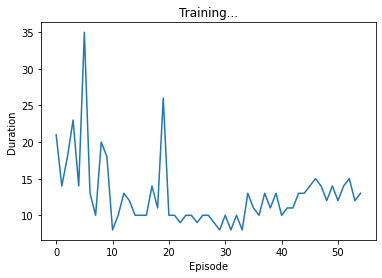

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 55 finished after 12 steps


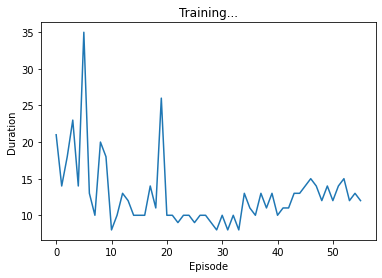

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 56 finished after 12 steps


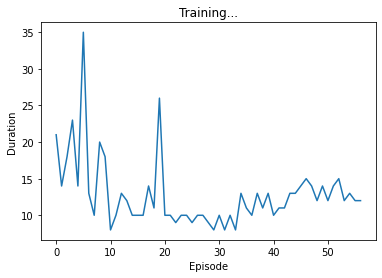

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 57 finished after 17 steps


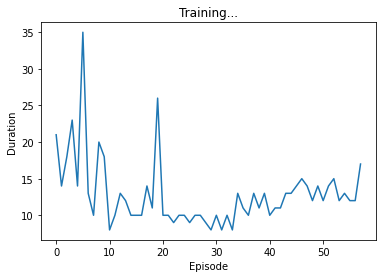

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 58 finished after 15 steps


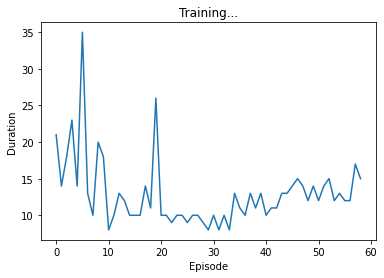

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 59 finished after 12 steps


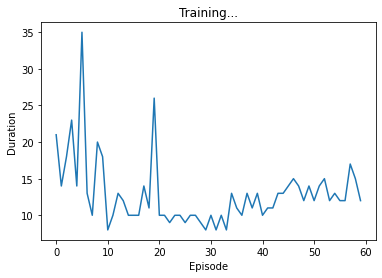

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 60 finished after 12 steps


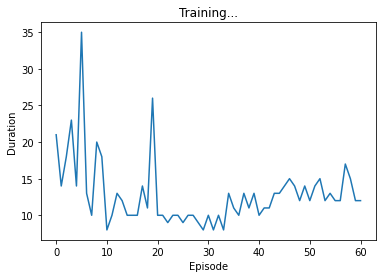

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 61 finished after 12 steps


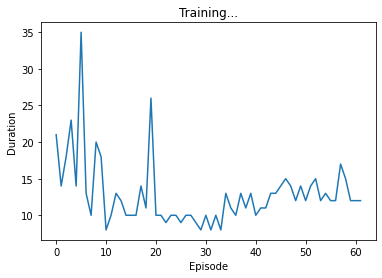

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 62 finished after 14 steps


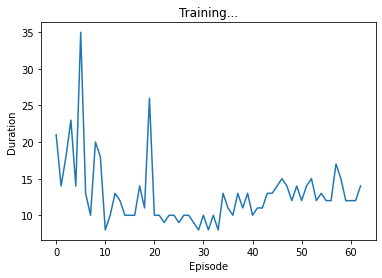

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 63 finished after 10 steps


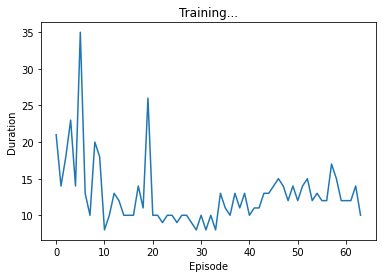

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 64 finished after 11 steps


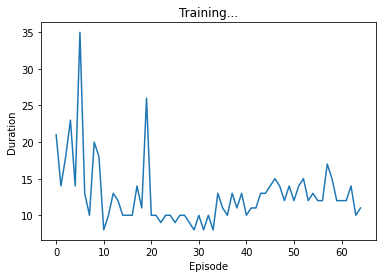

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 65 finished after 14 steps


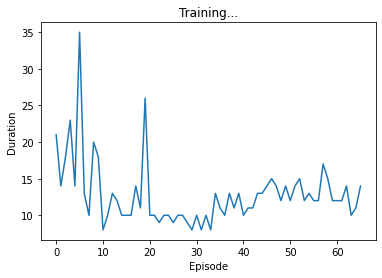

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 66 finished after 13 steps


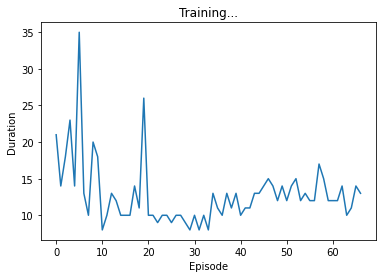

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 67 finished after 13 steps


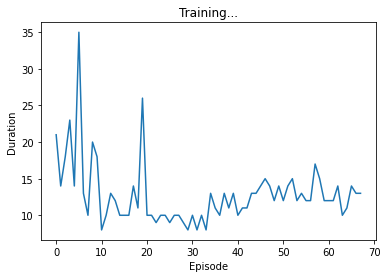

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 68 finished after 14 steps


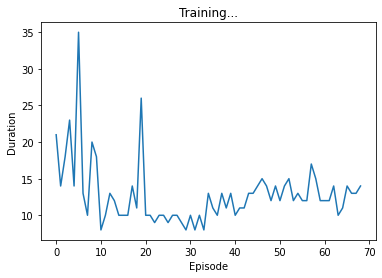

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 69 finished after 14 steps


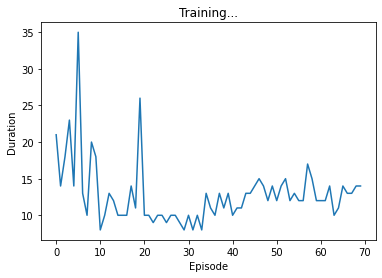

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 70 finished after 16 steps


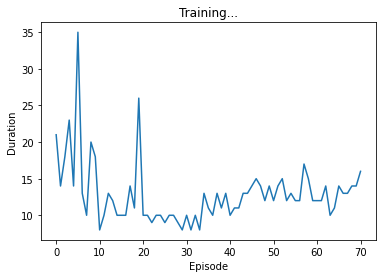

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 71 finished after 13 steps


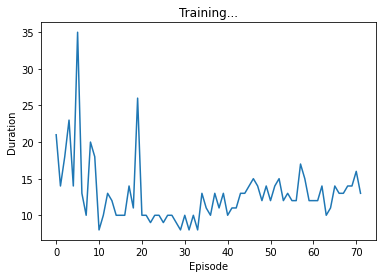

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 72 finished after 12 steps


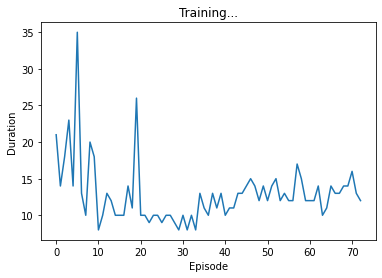

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 73 finished after 10 steps


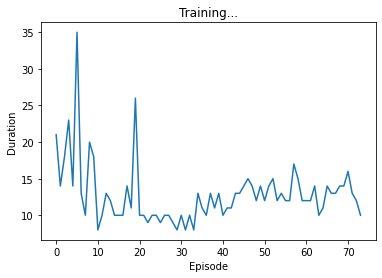

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 74 finished after 10 steps


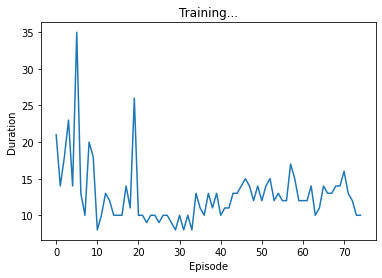

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 75 finished after 10 steps


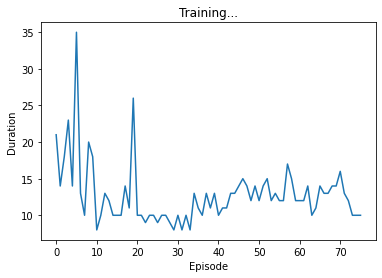

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 76 finished after 13 steps


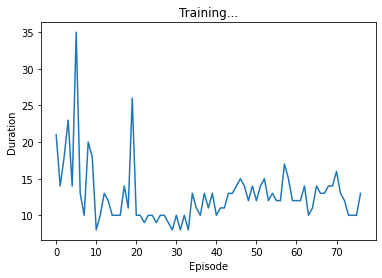

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 77 finished after 13 steps


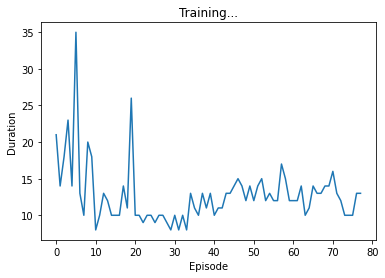

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 78 finished after 12 steps


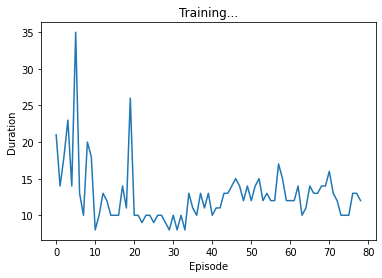

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 79 finished after 17 steps


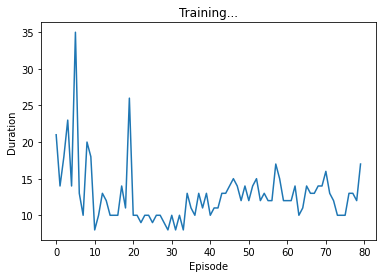

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 80 finished after 12 steps


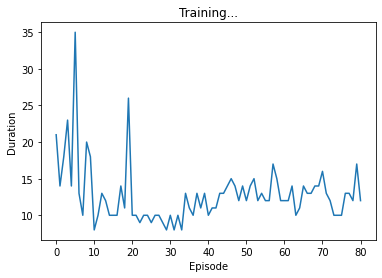

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 81 finished after 11 steps


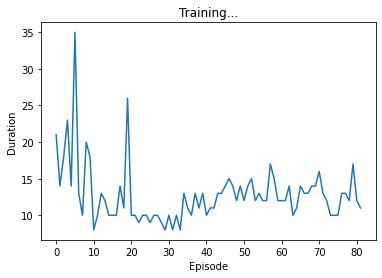

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 82 finished after 13 steps


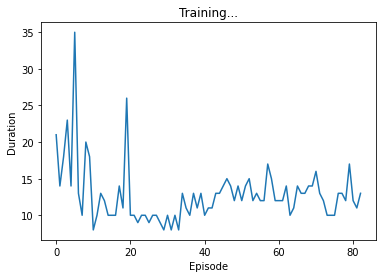

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 83 finished after 14 steps


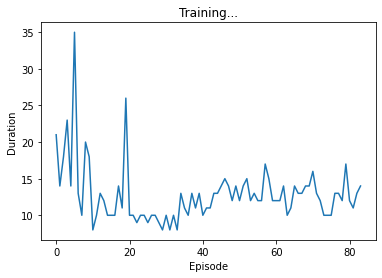

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 84 finished after 12 steps


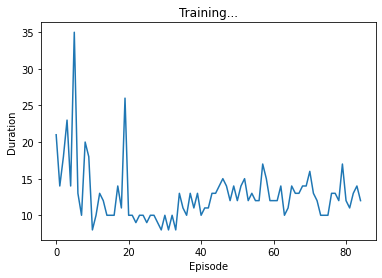

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 85 finished after 13 steps


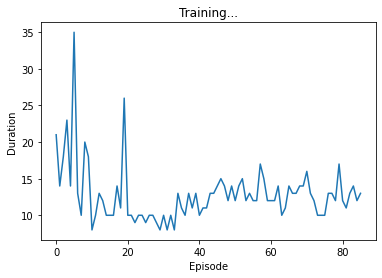

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 86 finished after 10 steps


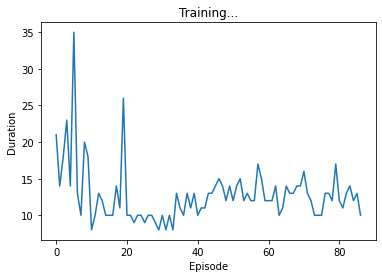

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 87 finished after 11 steps


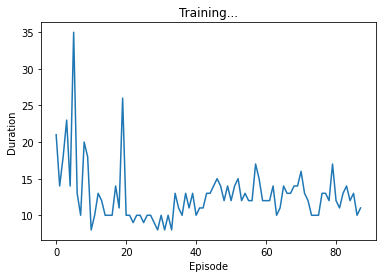

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 88 finished after 14 steps


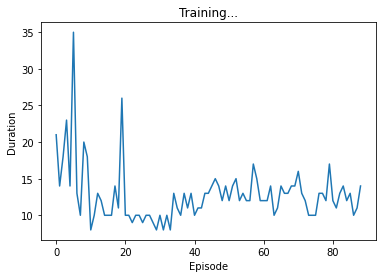

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 89 finished after 15 steps


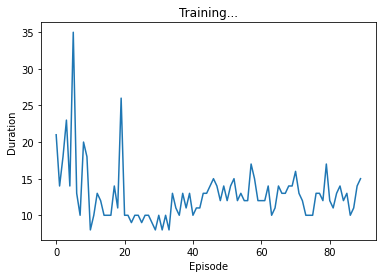

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 90 finished after 11 steps


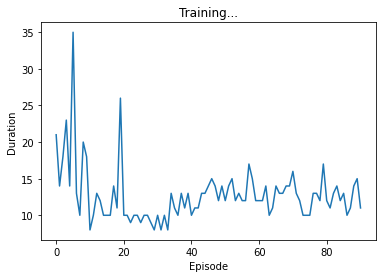

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 91 finished after 21 steps


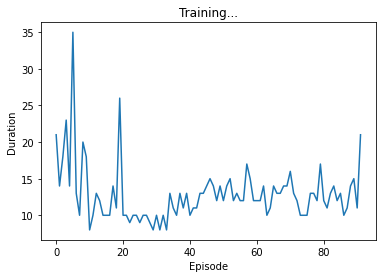

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 92 finished after 14 steps


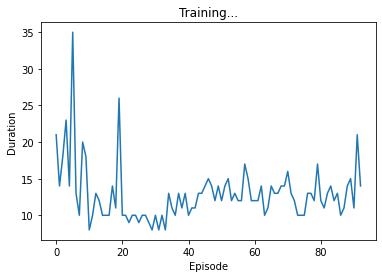

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 93 finished after 14 steps


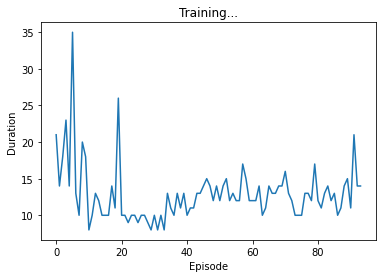

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 94 finished after 10 steps


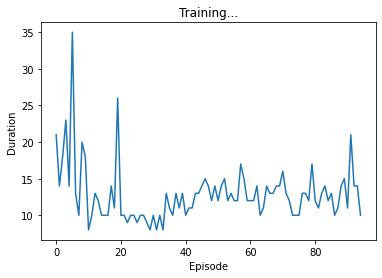

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 95 finished after 15 steps


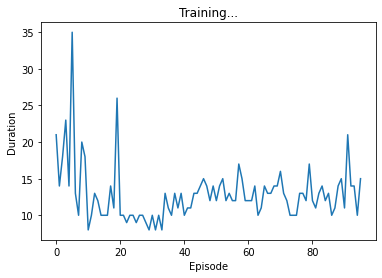

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 96 finished after 17 steps


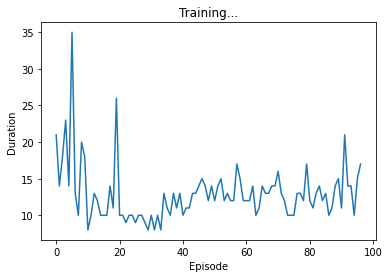

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 97 finished after 16 steps


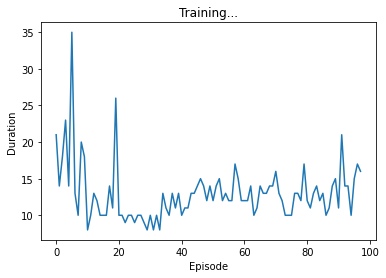

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 98 finished after 10 steps


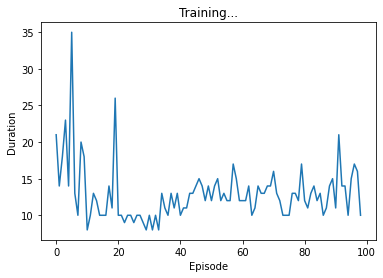

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 99 finished after 11 steps


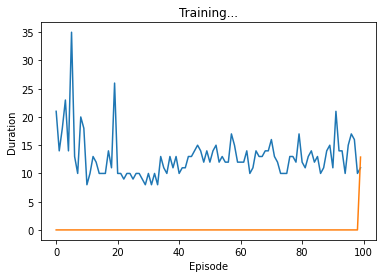

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 100 finished after 18 steps


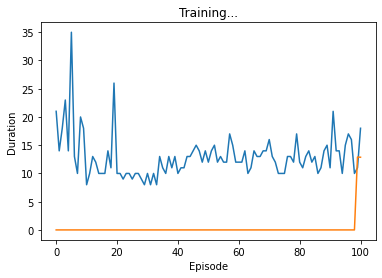

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 101 finished after 15 steps


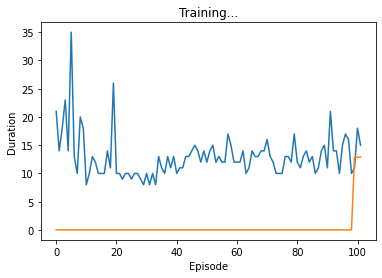

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 102 finished after 14 steps


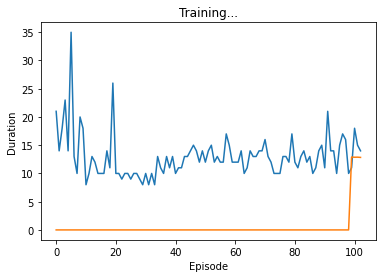

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 103 finished after 10 steps


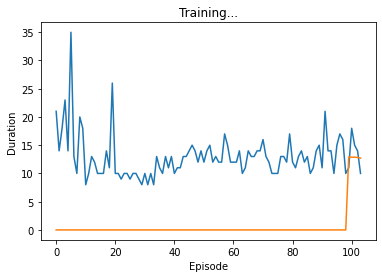

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 104 finished after 11 steps


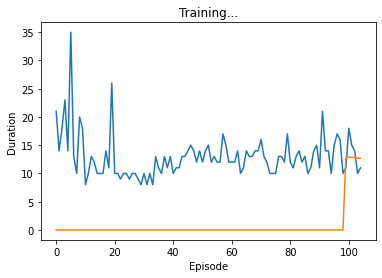

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 105 finished after 10 steps


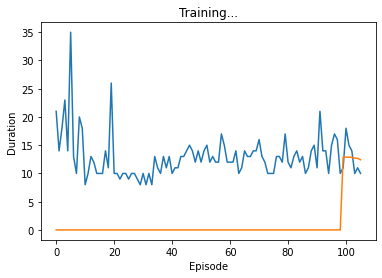

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 106 finished after 17 steps


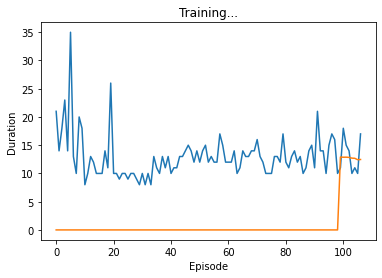

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 107 finished after 16 steps


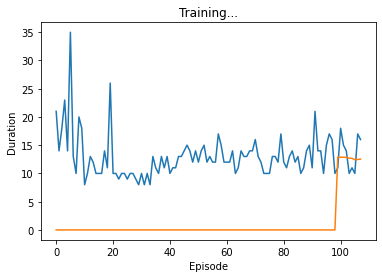

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 108 finished after 9 steps


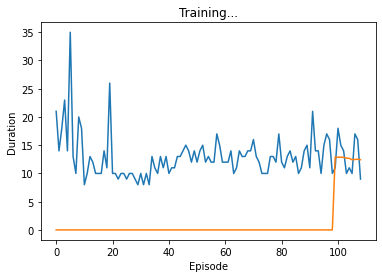

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 109 finished after 14 steps


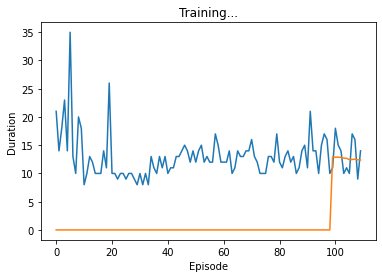

 Episode 110 finished after 8 steps


C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


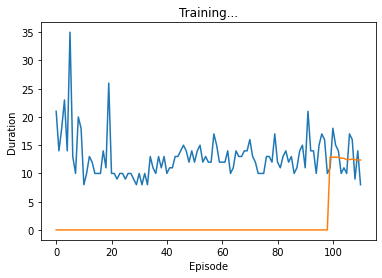

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 111 finished after 13 steps


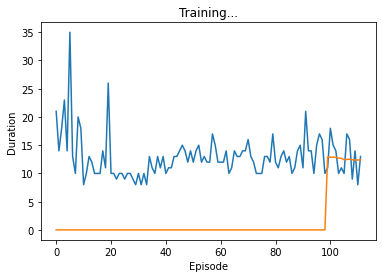

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 112 finished after 11 steps


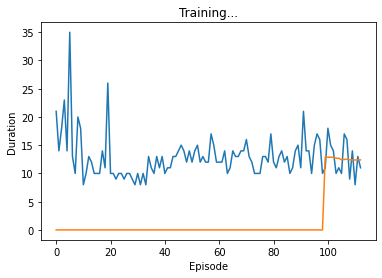

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 113 finished after 9 steps


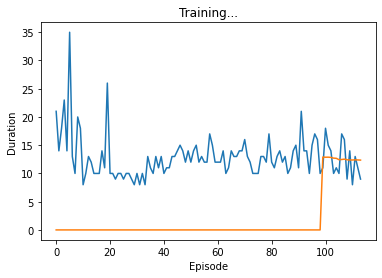

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 114 finished after 10 steps


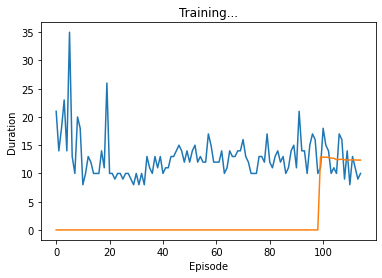

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 115 finished after 15 steps


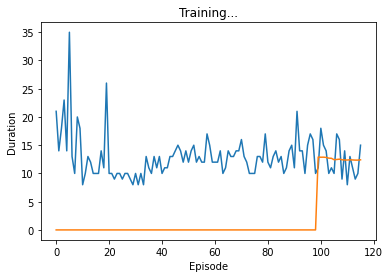

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 116 finished after 19 steps


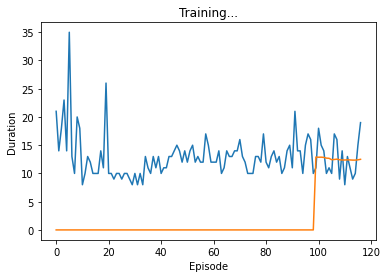

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 117 finished after 16 steps


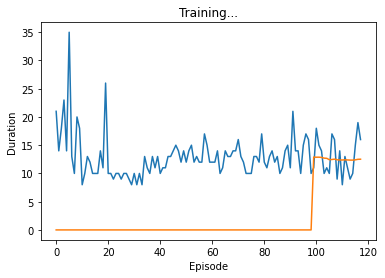

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 118 finished after 18 steps


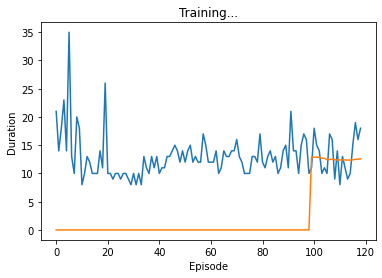

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 119 finished after 15 steps


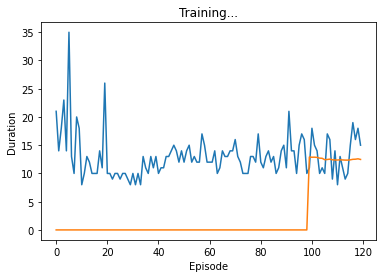

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 120 finished after 17 steps


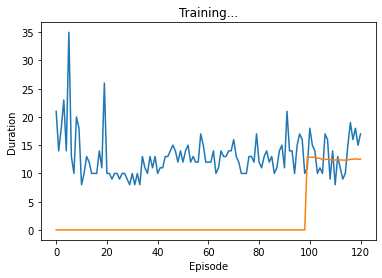

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 121 finished after 18 steps


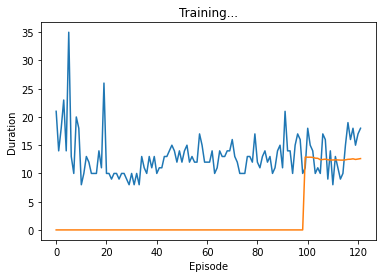

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 122 finished after 16 steps


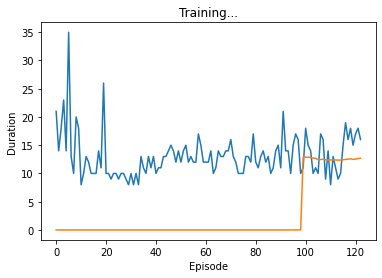

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 123 finished after 17 steps


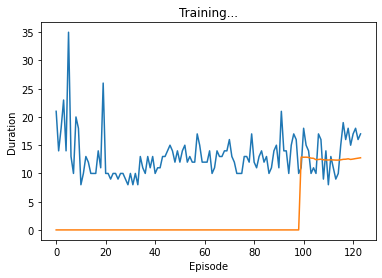

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 124 finished after 23 steps


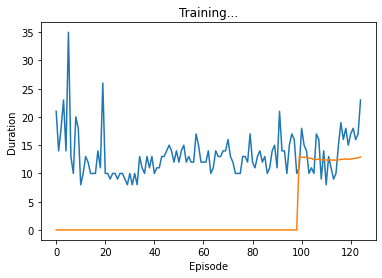

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 125 finished after 17 steps


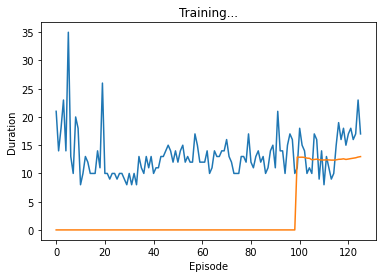

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 126 finished after 18 steps


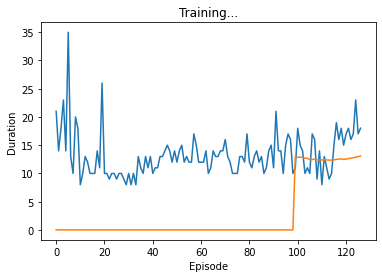

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 127 finished after 17 steps


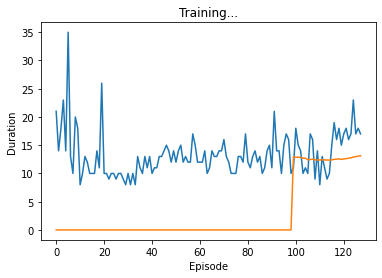

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 128 finished after 15 steps


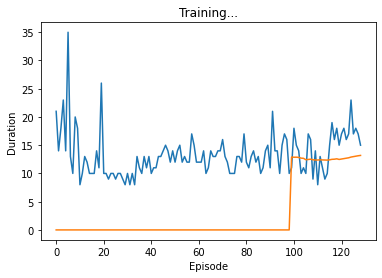

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 129 finished after 18 steps


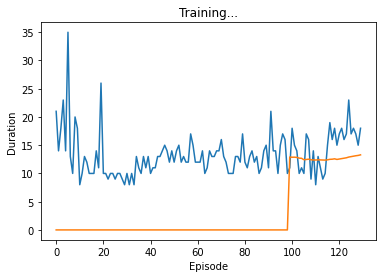

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 130 finished after 11 steps


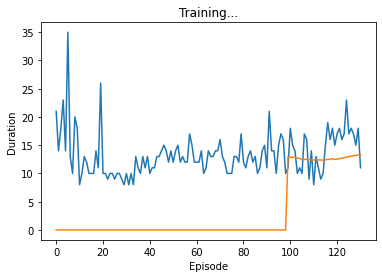

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 131 finished after 11 steps


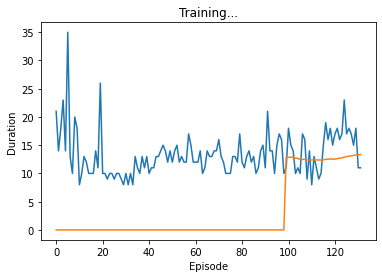

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 132 finished after 9 steps


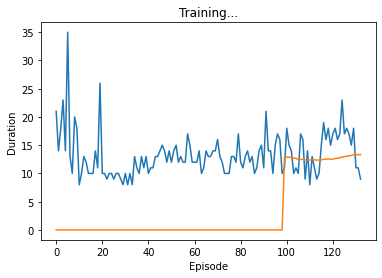

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 133 finished after 9 steps


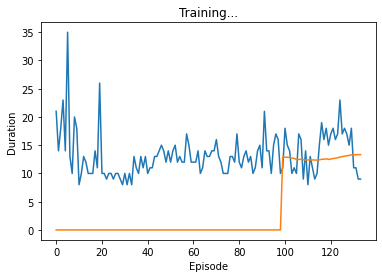

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 134 finished after 9 steps


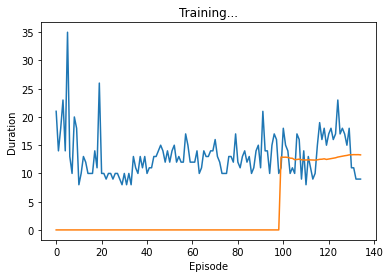

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 135 finished after 9 steps


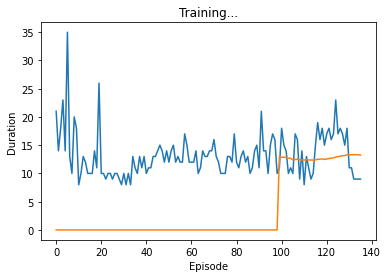

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 136 finished after 17 steps


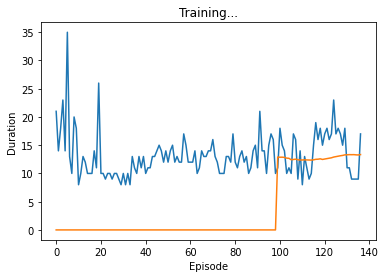

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 137 finished after 9 steps


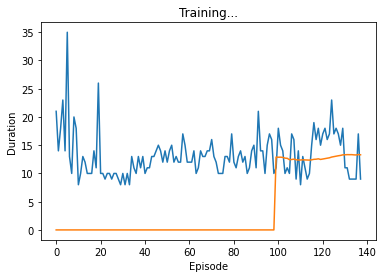

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 138 finished after 13 steps


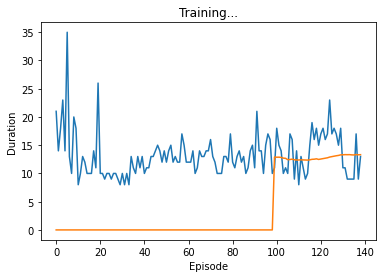

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 139 finished after 10 steps


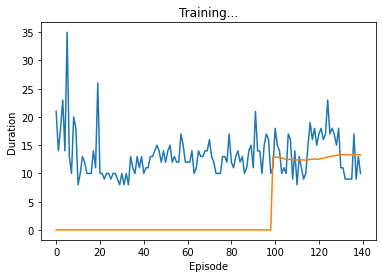

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 140 finished after 12 steps


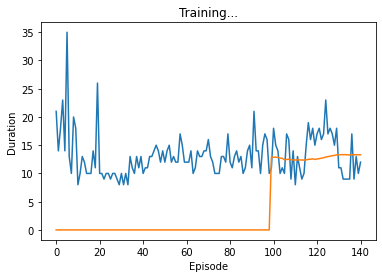

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


 Episode 141 finished after 10 steps


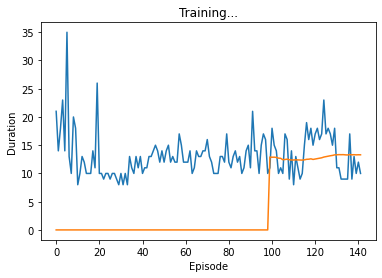

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 142 finished after 9 steps


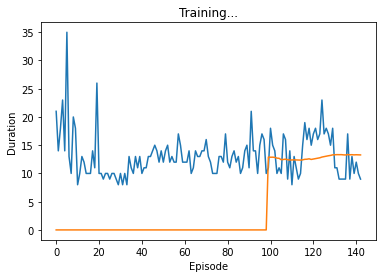

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 143 finished after 15 steps


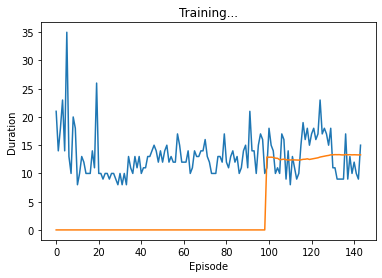

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 144 finished after 11 steps


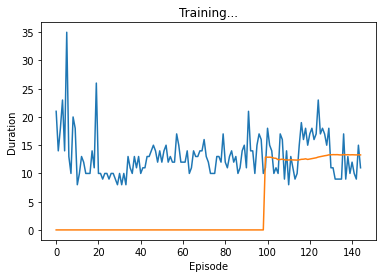

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 145 finished after 9 steps


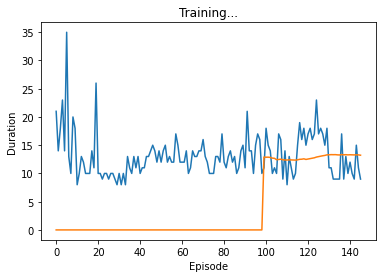

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 146 finished after 11 steps


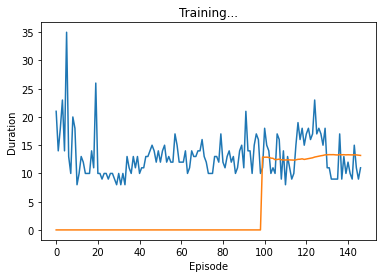

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 147 finished after 10 steps


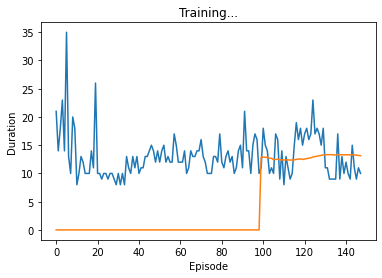

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 148 finished after 23 steps


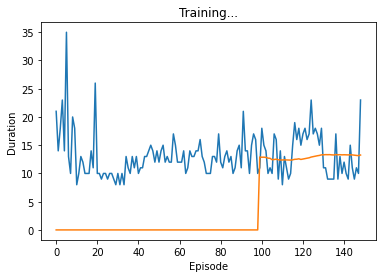

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 149 finished after 10 steps


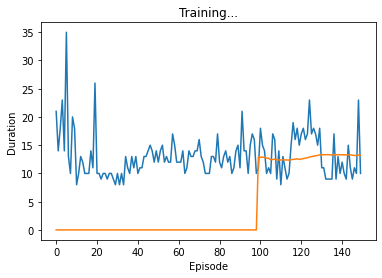

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 150 finished after 10 steps


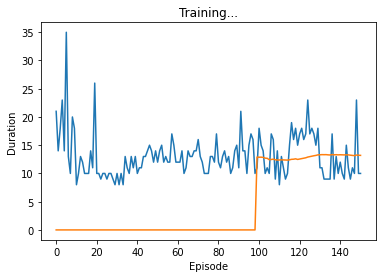

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 151 finished after 11 steps


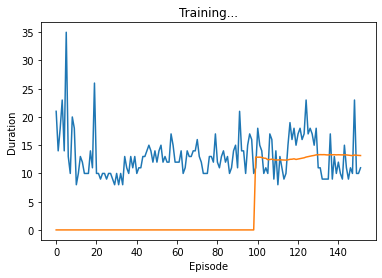

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 152 finished after 14 steps


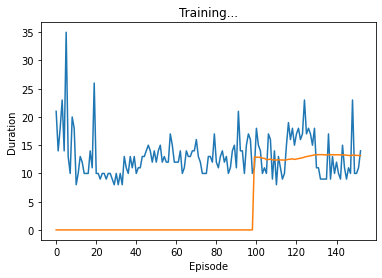

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 153 finished after 10 steps


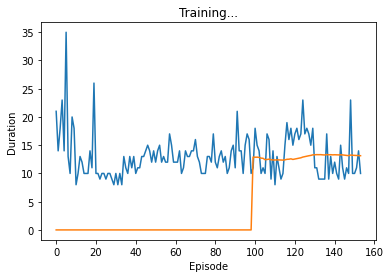

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 154 finished after 29 steps


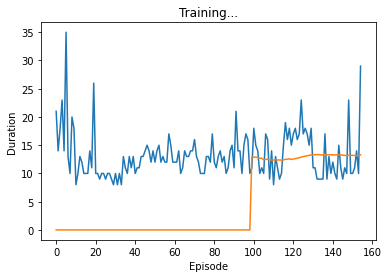

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 155 finished after 12 steps


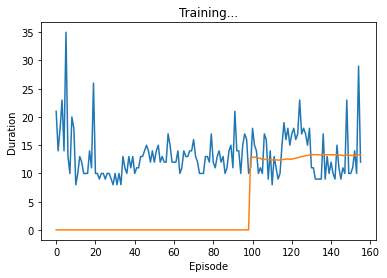

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 156 finished after 12 steps


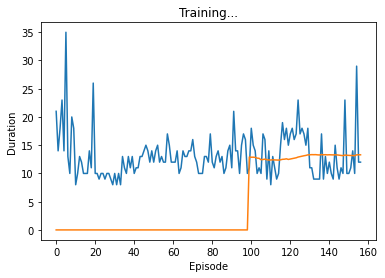

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 157 finished after 10 steps


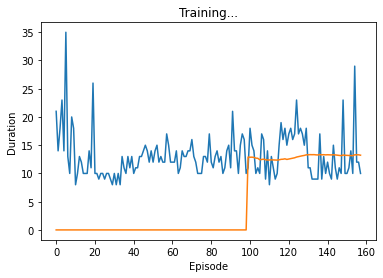

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 158 finished after 16 steps


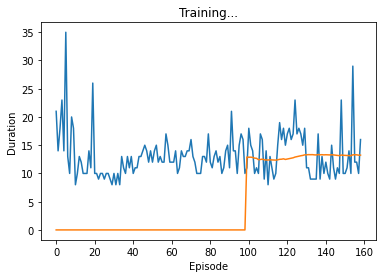

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 159 finished after 12 steps


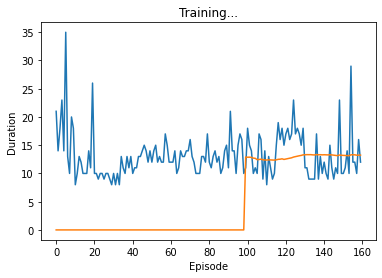

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 160 finished after 14 steps


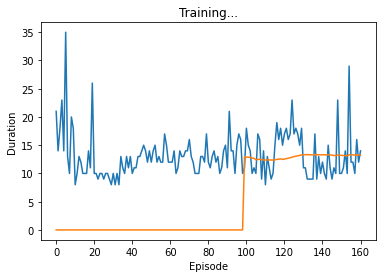

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 161 finished after 18 steps


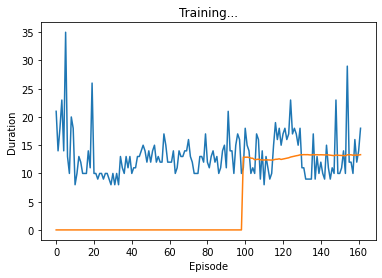

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 162 finished after 9 steps


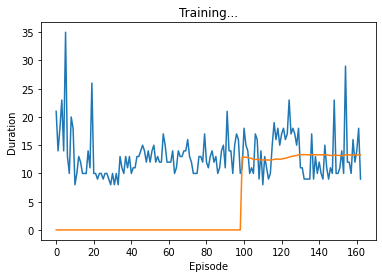

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 163 finished after 11 steps


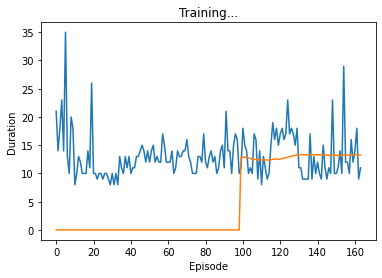

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 164 finished after 9 steps


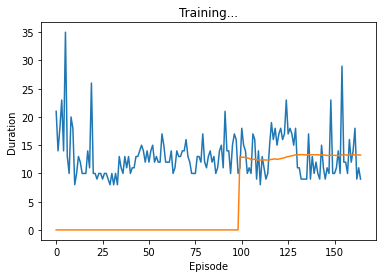

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 165 finished after 12 steps


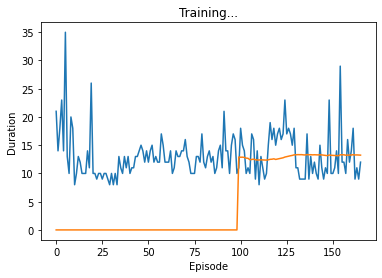

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 166 finished after 13 steps


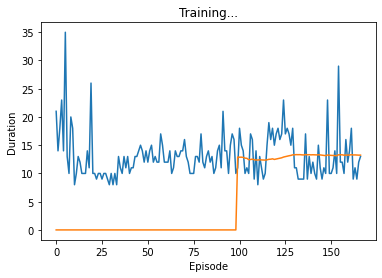

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 167 finished after 10 steps


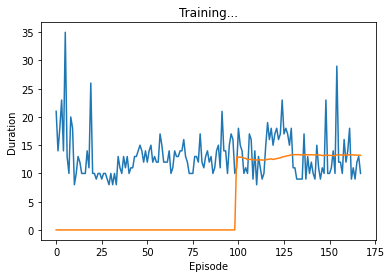

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 168 finished after 23 steps


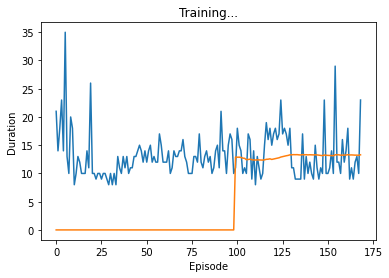

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 169 finished after 17 steps


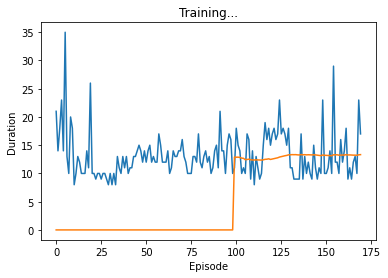

 Episode 170 finished after 8 steps


C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


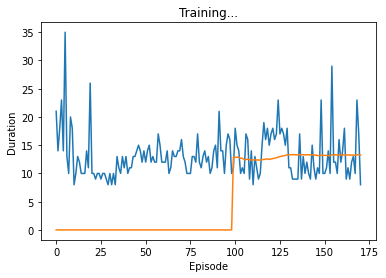

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 171 finished after 21 steps


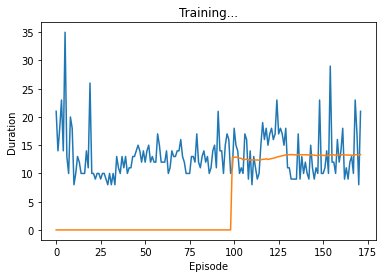

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 172 finished after 11 steps


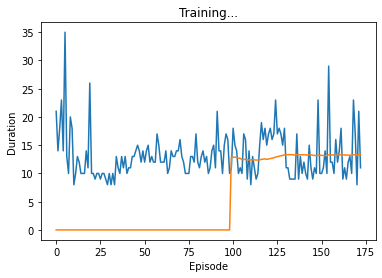

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 173 finished after 20 steps


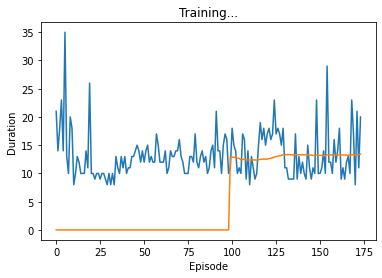

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 174 finished after 20 steps


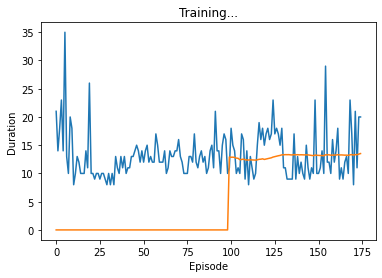

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 175 finished after 11 steps


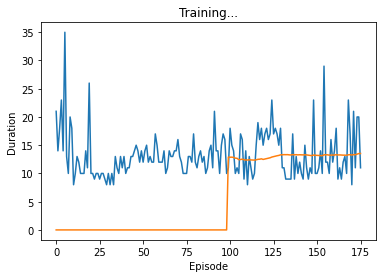

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 176 finished after 9 steps


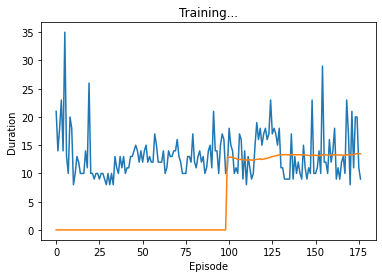

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 177 finished after 12 steps


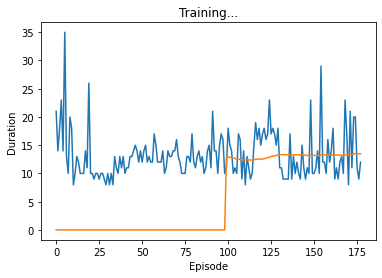

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 178 finished after 15 steps


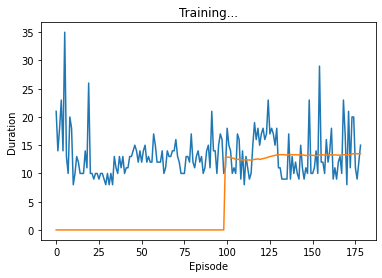

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


 Episode 179 finished after 16 steps


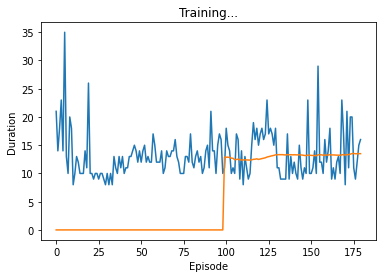

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


KeyboardInterrupt: 

In [11]:
for e in range(EPISODES):
    run_episode(e, env)

print('Complete')
env.render(close=True)
env.close()
plt.ioff()
plt.show()